In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.patches as patches
from sklearn.model_selection import cross_val_score

from scipy import interp


import warnings 
warnings.filterwarnings('ignore')
# Set random seed
np.random.seed(0)

In [2]:
# Random Forest ML model for predicting Service Time (350-476 OR 476-600)
# 80-20% train test split
data = pd.read_csv("ServiceTimeBinaryBothFinal.csv")
data.head()

X = data.ix[:,(0,1,2,3,4,5)].values
y = data.ix[:,6].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)
clf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [3]:
# Collecting F-1 score, precision, recall
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.79      0.81        29
           2       0.70      0.74      0.72        19

   micro avg       0.77      0.77      0.77        48
   macro avg       0.76      0.76      0.76        48
weighted avg       0.77      0.77      0.77        48



In [4]:
# Collecting Precision score (Accuracy)
print('Random Forest Model accuracy for train-test split: ', round(precision_score(y_test,y_pred,average='weighted') * 100, 3), '% ')

Random Forest Model accuracy for train-test split:  77.336 % 


In [5]:
print('Random Forest Model F-1 score for train-test split: ', round(f1_score(y_test,y_pred,average='weighted'), 3))

Random Forest Model F-1 score for train-test split:  0.772


In [6]:
print('Random Forest Model Confusion Matrix for train-test split: \n ', confusion_matrix(y_test,y_pred))

Random Forest Model Confusion Matrix for train-test split: 
  [[23  6]
 [ 5 14]]


In [9]:
# Random Forest ML model for predicting Service Time (350-476 OR 476-600)
# 10-fold cross validation 
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
cv = StratifiedKFold(n_splits=10,shuffle=False)
print ('Random Forest Accuracy:', round(np.mean(cross_val_score(clf, X, y, cv=10)),4) * 100, ' %' )

Random Forest Accuracy: 62.470000000000006  %


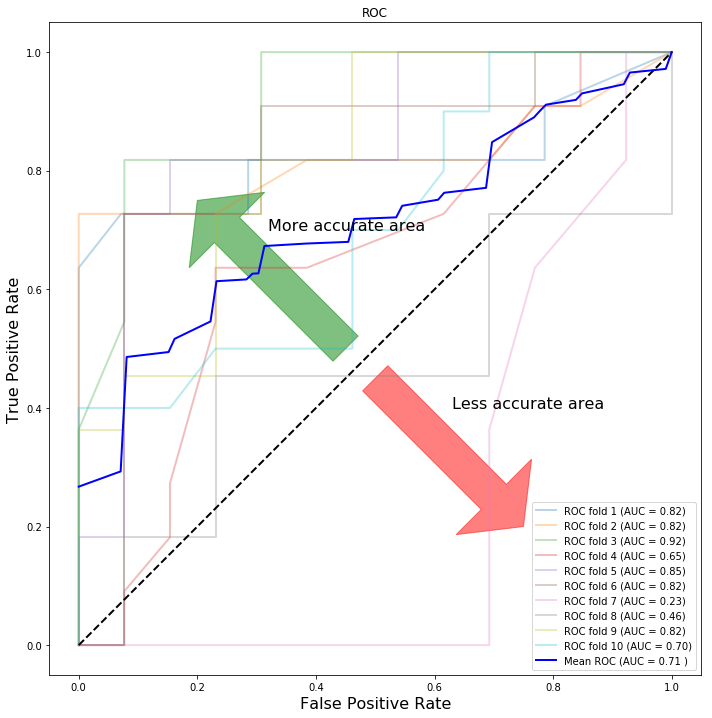

In [10]:
# ROC curve
data = pd.read_csv("ServiceTimeBinaryBothFinal.csv")
dict = {2:1,1:0}      # label = column name
data['Quality Score'] = data['Quality Score'].map(dict)

random_state = np.random.RandomState(0)
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
cv = StratifiedKFold(n_splits=10,shuffle=False)

x = data.loc[:, data.columns != 'Quality Score']
y = data.loc[:,'Quality Score']
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])[:, 1]
    fpr, tpr, t = roc_curve(y[test], prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate',fontsize = 16)
plt.ylabel('True Positive Rate',fontsize = 16)
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 16)
plt.text(0.63,0.4,'Less accurate area',fontsize = 16)
plt.show()